In [3]:
import os
import glob
import pandas as pd
import numpy as np
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt

import ast

In [21]:


def load_masks_from_directory(mask_dir):
    """
    Load all TIFF binary mask images from a directory. 
    Assumes each mask file is named something like 'node_1.tiff', 'edge_1-2.tiff', etc.
    Returns a dictionary: 
        key = subcomponent name (e.g. 'node_1'), 
        value = 2D numpy array for the binary mask.
    """
    mask_dict = {}
    # Adjust the pattern below if your TIFFs follow a different naming convention
    tiff_files = glob.glob(os.path.join(mask_dir, "*.tif*"))

    for tiff_path in tiff_files:
        # Extract subcomponent name from filename (e.g., 'node_1' from 'node_1.tif')
        filename = os.path.basename(tiff_path)
        # Remove file extension to get subcomponent label
        subcomponent_name, _ = os.path.splitext(filename)
        
        # Read the binary mask as a 2D numpy array
        mask_array = tifffile.imread(tiff_path)
        
        # If the mask is not already boolean, ensure it is cast properly
        # (assuming 255 for True, 0 for False, or 1 for True, 0 for False)
        mask_array = mask_array.astype(bool)
        
        mask_dict[subcomponent_name] = mask_array
    
    return mask_dict


def map_body_parts_to_subcomponent(sleap_csv_path, mask_dir, output_csv_path, 
                                   bodypart_names=None, x_suffix=".x", y_suffix=".y"):
    """
    Loads a SLEAP CSV of body part coordinates, loads TIFF binary masks for maze subcomponents,
    and outputs a new CSV where each column is a body part and each row is the subcomponent 
    where that body part resides at that timepoint.

    Args:
        sleap_csv_path (str): Path to the SLEAP CSV file.
        mask_dir (str): Directory containing the binary mask TIFF files.
        output_csv_path (str): Path for saving the output CSV.
        bodypart_names (list): If None, the code will infer them from CSV column names
                               (anything ending with x_suffix or y_suffix).
        x_suffix (str): Suffix used in the CSV for the x-coordinate columns (default "_x").
        y_suffix (str): Suffix used in the CSV for the y-coordinate columns (default "_y").
    """
    # 1. Load the SLEAP CSV
    sleap_df = pd.read_csv(sleap_csv_path)
    
    # If user hasn't specified the bodypart names, infer them from columns
    if bodypart_names is None:
        # If columns look like 'nose_x', 'nose_y', 'tail_x', 'tail_y', etc.
        # then we identify them by removing the suffixes
        x_cols = [col for col in sleap_df.columns if col.endswith(x_suffix)]
        bodypart_names = [col.replace(x_suffix, "") for col in x_cols]

    # 2. Load all the binary masks
    masks = load_masks_from_directory(mask_dir)
    plt.matshow(masks["node_1"])
    # masks is a dict: subcomponent_name -> boolean 2D array

    # 3. Prepare output DataFrame: 
    # one row per row in SLEAP CSV, columns = bodypart names
    # each cell will eventually be the subcomponent name (str)
    output_df = pd.DataFrame(index=sleap_df.index, columns=bodypart_names, dtype=object)

    # 4. For each row (timepoint) in SLEAP, for each body part:
    #    find which subcomponent mask is True at that coordinate
    for i, row_data in sleap_df.iterrows():
        # For each body part:
        for bp in bodypart_names:
            x_col = f"{bp}{x_suffix}"
            y_col = f"{bp}{y_suffix}"

            if x_col not in sleap_df.columns or y_col not in sleap_df.columns:
                # If for some reason these columns aren't present, skip
                output_df.at[i, bp] = None
                continue

            x_coord = row_data[x_col]
            y_coord = row_data[y_col]

            # Round or convert the float coordinates to integer indices
            # SLEAP outputs may be float, whereas the mask arrays use integer pixel indices
            x_idx = int(round(x_coord))
            y_idx = int(round(y_coord))
            
            # Handle edge cases: if out of image bounds, skip or label as None
            # First, pick an approach. Let's label out-of-bounds as "None" or "outside".
            # Adjust if you prefer some other convention.
            in_bounds = True
            mask_shape = None
            for subcomponent_name, mask_array in masks.items():
                mask_shape = mask_array.shape
                break

            if mask_shape is not None:
                height, width = mask_shape
                if x_idx < 0 or x_idx >= width or y_idx < 0 or y_idx >= height:
                    # Out of bounds
                    output_df.at[i, bp] = "None"
                    continue
            
            # Now find which mask is True at (y_idx, x_idx).
            # We assume only one subcomponent is True at a given point,
            # or if multiple are True, we take the first. 
            # Adjust logic as needed.
            found_subcomponent = False
            for subcomponent_name, mask_array in masks.items():
                # mask_array[y, x] = True if inside that subcomponent
                if mask_array[y_idx, x_idx]:
                    output_df.at[i, bp] = subcomponent_name
                    found_subcomponent = True
                    break
            
            if not found_subcomponent:
                # Not found in any mask; label as None or "background"
                output_df.at[i, bp] = "None"

    # 5. Save out the new CSV
    output_df.to_csv(output_csv_path, index=False)
    print(f"Output saved to: {output_csv_path}")





head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_back.x
ear_L.x
ear_R.x
body_front.x
body_mid.x
body_back.x
head_front.x
head_mid.x
head_bac

ValueError: cannot convert float NaN to integer

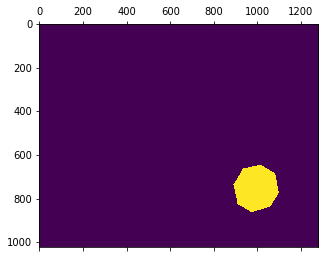

In [23]:
sleap_csv = "/Users/AdamHarris/Desktop/mEC_SLEAP/labels.v004.025_bp01_2024-03-31-163524.analysis.csv"
masks_directory = "/Users/AdamHarris/Desktop/bp01_Masks/late/"
output_csv = "/Users/AdamHarris/Desktop/output_ROI.csv"

map_body_parts_to_subcomponent(
    sleap_csv_path=sleap_csv,
    mask_dir=masks_directory,
    output_csv_path=output_csv,
    # Optional: explicitly list bodypart names if you know them; else it infers from columns
    bodypart_names=None,
    x_suffix=".x",
    y_suffix=".y"
)

In [12]:
sleap_df = pd.read_csv(sleap_csv)

In [19]:
x_cols = [col for col in sleap_df.columns if col.endswith(".x")]
bodypart_names = [col.replace(".x", "") for col in x_cols]

In [20]:
bodypart_names

['head_front',
 'head_mid',
 'head_back',
 'ear_L',
 'ear_R',
 'body_front',
 'body_mid',
 'body_back']

In [24]:
import math

In [26]:
print(math.e)

2.718281828459045


In [27]:
import os
import glob
import pandas as pd
import numpy as np
import tifffile


def load_masks_from_directory(mask_dir):
    """
    Load all TIFF binary mask images from a directory. 
    Assumes each mask file is named like 'node_1.tif', 'edge_1-2.tif', etc.
    Returns a dictionary: 
        key = subcomponent name (e.g. 'node_1'), 
        value = 2D numpy array for the binary mask.
    """
    mask_dict = {}
    tiff_files = glob.glob(os.path.join(mask_dir, "*.tif*"))

    for tiff_path in tiff_files:
        filename = os.path.basename(tiff_path)
        # Remove file extension to get subcomponent label
        subcomponent_name, _ = os.path.splitext(filename)
        
        # Read the binary mask as a 2D numpy array
        mask_array = tifffile.imread(tiff_path)
        
        # Ensure boolean type (True/False)
        mask_array = mask_array.astype(bool)
        
        mask_dict[subcomponent_name] = mask_array
    
    return mask_dict


def detect_outliers_by_jump(df, bodypart_names, x_suffix, y_suffix,
                            distance_threshold=None,
                            robust=True, multiplier=3.0):
    """
    Detect outliers based on large frame-to-frame jumps for each bodypart.
    If the distance between consecutive frames exceeds a certain threshold,
    mark those coordinates as NaN.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The data containing body part coordinates (e.g. from a SLEAP CSV).
    bodypart_names : list of str
        List of bodypart labels to process (e.g. ["nose", "tail"]).
    x_suffix : str
        Suffix for x-coordinates (e.g. ".x" or "_x").
    y_suffix : str
        Suffix for y-coordinates.
    distance_threshold : float or None
        If a float, use this fixed threshold (in pixels).
        If None, compute a robust threshold from the distribution of frame-to-frame distances
        using median absolute deviation (MAD) or standard deviation, as specified by 'robust'.
    robust : bool
        If True and distance_threshold is None, use median absolute deviation to set a threshold.
        If False and distance_threshold is None, use mean + multiplier * std.
    multiplier : float
        The multiplier for the robust or standard deviation approach. E.g., 3.0 for 3*MAD or 3*std.
    
    Returns:
    --------
    pd.DataFrame
        A copy of df where outliers have been marked as NaN.
    """
    df_out = df.copy()

    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        if x_col not in df_out.columns or y_col not in df_out.columns:
            continue
        
        x_vals = df_out[x_col].values
        y_vals = df_out[y_col].values

        # Calculate frame-to-frame distances
        # distance[i] = distance between (x[i], y[i]) and (x[i-1], y[i-1])
        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        dist = np.sqrt(dx**2 + dy**2)
        
        # If no threshold provided, compute from data
        if distance_threshold is None:
            # We'll skip NaNs in dist
            dist_no_nan = dist[~np.isnan(dist)]
            if len(dist_no_nan) == 0:
                # no valid distances, skip
                continue
            if robust:
                # Use median + multiplier * MAD
                median_dist = np.median(dist_no_nan)
                mad = np.median(np.abs(dist_no_nan - median_dist))
                # A common robust scale factor for MAD is 1.4826,
                # but we can keep it simple or adapt as needed.
                if mad == 0:
                    # fallback if all distances are the same
                    distance_threshold = median_dist * multiplier
                else:
                    distance_threshold = median_dist + multiplier * mad
            else:
                # Use mean + multiplier * std
                mean_dist = np.mean(dist_no_nan)
                std_dist = np.std(dist_no_nan)
                distance_threshold = mean_dist + multiplier * std_dist

        # Now we have a distance_threshold, let's mark outliers
        # dist[i] corresponds to jump from frame i to i+1 in x_vals
        # We can mark frame i+1 as NaN if dist[i] is above threshold
        outlier_indices = np.where(dist > distance_threshold)[0] + 1  # shift by 1 for the "destination" frame

        # Mark outliers as NaN
        x_vals[outlier_indices] = np.nan
        y_vals[outlier_indices] = np.nan

        # Save back
        df_out[x_col] = x_vals
        df_out[y_col] = y_vals
    
    return df_out


def interpolate_and_smooth_coordinates(df, bodypart_names, x_suffix, y_suffix,
                                       interpolation_method='linear', 
                                       rolling_window=5):
    """
    For each bodypart.x and bodypart.y column:
      1. Perform NaN interpolation (default 'linear').
      2. Smooth data with a rolling mean of specified window size.
    """
    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        # Skip if columns don't exist
        if x_col not in df.columns or y_col not in df.columns:
            continue

        # Interpolation (fills internal NaNs, can also do 'limit_direction' or 'order' if polynomial, etc.)
        df[x_col] = df[x_col].interpolate(method=interpolation_method, limit_direction='both')
        df[y_col] = df[y_col].interpolate(method=interpolation_method, limit_direction='both')

        # Smoothing with rolling mean
        df[x_col] = df[x_col].rolling(window=rolling_window, min_periods=1, center=True).mean()
        df[y_col] = df[y_col].rolling(window=rolling_window, min_periods=1, center=True).mean()

    return df


def map_body_parts_to_subcomponent(sleap_csv_path, 
                                   mask_dir, 
                                   output_csv_path, 
                                   bodypart_names=None, 
                                   x_suffix="_x", 
                                   y_suffix="_y",
                                   # Outlier detection parameters
                                   outlier_detection=True,
                                   distance_threshold=None,
                                   robust=True,
                                   multiplier=3.0,
                                   # Interpolation & smoothing parameters
                                   interpolation_method='linear',
                                   rolling_window=5):
    """
    1) Loads SLEAP CSV of body part coordinates
    2) Optionally detects & removes large jump outliers
    3) Interpolates + smooths
    4) Loads TIFF binary masks
    5) Maps each body part's (x,y) to a subcomponent
    6) Exports the final mapping in a CSV
    
    Args:
        sleap_csv_path (str): Path to the SLEAP CSV file.
        mask_dir (str): Directory containing the binary mask TIFF files.
        output_csv_path (str): Path for saving the output CSV.
        bodypart_names (list): If None, the code will infer from CSV col names that end with x_suffix/y_suffix.
        x_suffix (str): Suffix for x coordinates (default "_x").
        y_suffix (str): Suffix for y coordinates (default "_y").
        
        outlier_detection (bool): Whether to do outlier detection by large jumps.
        distance_threshold (float or None): If float, fixed threshold in pixels. If None, auto-calc from data.
        robust (bool): If True and threshold is None, use median+MAD approach; else use mean+std.
        multiplier (float): Multiplier for outlier detection threshold.
        
        interpolation_method (str): Pandas interpolation method (e.g., 'linear', 'time', 'polynomial', etc.).
        rolling_window (int): Window size for rolling average smoothing.
    """
    # 1. Load SLEAP CSV
    sleap_df = pd.read_csv(sleap_csv_path)
    
    # If user hasn't specified bodypart names, infer them from columns
    if bodypart_names is None:
        x_cols = [col for col in sleap_df.columns if col.endswith(x_suffix)]
        bodypart_names = [col.replace(x_suffix, "") for col in x_cols]

    # 2. Outlier detection & removal
    if outlier_detection:
        sleap_df = detect_outliers_by_jump(
            sleap_df, 
            bodypart_names, 
            x_suffix, 
            y_suffix,
            distance_threshold=distance_threshold,
            robust=robust, 
            multiplier=multiplier
        )

    # 3. Interpolate & smooth
    sleap_df = interpolate_and_smooth_coordinates(
        sleap_df, 
        bodypart_names, 
        x_suffix, 
        y_suffix,
        interpolation_method=interpolation_method, 
        rolling_window=rolling_window
    )

    # 4. Load binary masks
    masks = load_masks_from_directory(mask_dir)
    # We assume consistent shape
    mask_shape = None
    if len(masks) > 0:
        first_key = next(iter(masks.keys()))
        mask_shape = masks[first_key].shape

    # 5. Map each body part to subcomponent
    output_df = pd.DataFrame(index=sleap_df.index, columns=bodypart_names, dtype=object)

    for i, row_data in sleap_df.iterrows():
        for bp in bodypart_names:
            x_col = f"{bp}{x_suffix}"
            y_col = f"{bp}{y_suffix}"

            if x_col not in sleap_df.columns or y_col not in sleap_df.columns:
                output_df.at[i, bp] = "None"
                continue

            x_coord = row_data[x_col]
            y_coord = row_data[y_col]

            if pd.isna(x_coord) or pd.isna(y_coord):
                output_df.at[i, bp] = "None"
                continue
            
            x_idx = int(round(x_coord))
            y_idx = int(round(y_coord))

            # Check bounds
            if mask_shape is not None:
                h, w = mask_shape
                if x_idx < 0 or x_idx >= w or y_idx < 0 or y_idx >= h:
                    output_df.at[i, bp] = "None"
                    continue

            # Identify which mask is True
            found_subcomponent = False
            for subcomp_name, mask_arr in masks.items():
                if mask_arr[y_idx, x_idx]:
                    output_df.at[i, bp] = subcomp_name
                    found_subcomponent = True
                    break
            if not found_subcomponent:
                output_df.at[i, bp] = "None"

    # 6. Save final output
    output_df.to_csv(output_csv_path, index=False)
    print(f"Output saved to: {output_csv_path}")


# -------------------------
# Example usage (if needed):
# -------------------------
if __name__ == "__main__":
    # Example file paths
    sleap_csv = "/Users/AdamHarris/Desktop/mEC_SLEAP/labels.v004.025_bp01_2024-03-31-163524.analysis.csv"
    masks_directory = "/Users/AdamHarris/Desktop/bp01_Masks/late/"
    output_csv = "/Users/AdamHarris/Desktop/output_ROI.csv"

    map_body_parts_to_subcomponent(
        sleap_csv_path=sleap_csv,
        mask_dir=masks_directory,
        output_csv_path=output_csv,
        bodypart_names=None,             # or e.g. ["nose", "tail_base", "left_ear", "right_ear", ...]
        x_suffix=".x",                  # if your columns are like "nose.x", "nose.y"
        y_suffix=".y",                  #
        outlier_detection=True,
        distance_threshold=None,        # auto-compute from data
        robust=True,                    # use median+MAD approach
        multiplier=3.0,                 # threshold = median_dist + 3.0*MAD
        interpolation_method='linear',
        rolling_window=5                # window for rolling average
    )


/Users/AdamHarris/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in greater


Output saved to: /Users/AdamHarris/Desktop/output_ROI.csv


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import tifffile

def load_masks_from_directory(mask_dir):
    """
    Load all TIFF binary mask images from a directory.
    Returns a dictionary: subcomponent_name -> 2D boolean numpy array.
    """
    mask_dict = {}
    tiff_files = glob.glob(os.path.join(mask_dir, "*.tif*"))

    for tiff_path in tiff_files:
        filename = os.path.basename(tiff_path)
        # Remove file extension to get subcomponent label (e.g. "node_1" from "node_1.tif")
        subcomponent_name, _ = os.path.splitext(filename)
        
        # Read the binary mask as a 2D numpy array
        mask_array = tifffile.imread(tiff_path)
        
        # Ensure it's boolean
        mask_array = mask_array.astype(bool)
        
        mask_dict[subcomponent_name] = mask_array
    
    return mask_dict


def detect_outliers_by_jump(df, bodypart_names, x_suffix, y_suffix,
                            distance_threshold=None,
                            robust=True, multiplier=3.0):
    """
    Mark body-part positions as NaN if the frame-to-frame jump
    exceeds a distance threshold.
    
    If distance_threshold is None, it is computed from the distribution
    of all distances using either:
      - median + multiplier * MAD (if robust=True), or
      - mean + multiplier * std  (if robust=False).
    """
    df_out = df.copy()

    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        # Skip if columns don't exist
        if x_col not in df_out.columns or y_col not in df_out.columns:
            continue
        
        x_vals = df_out[x_col].values
        y_vals = df_out[y_col].values

        # Calculate frame-to-frame distances
        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        dist = np.sqrt(dx**2 + dy**2)
        
        # If no threshold provided, auto-compute from the data
        if distance_threshold is None:
            dist_no_nan = dist[~np.isnan(dist)]
            if len(dist_no_nan) == 0:
                # No valid distances, skip
                continue

            if robust:
                # Use median + multiplier * MAD
                median_dist = np.median(dist_no_nan)
                mad = np.median(np.abs(dist_no_nan - median_dist))
                if mad == 0:
                    distance_threshold = median_dist * multiplier
                else:
                    distance_threshold = median_dist + multiplier * mad
            else:
                # mean + multiplier * std
                mean_dist = np.mean(dist_no_nan)
                std_dist = np.std(dist_no_nan)
                distance_threshold = mean_dist + multiplier * std_dist

        # dist[i] is jump from frame i to i+1
        outlier_indices = np.where(dist > distance_threshold)[0] + 1
        # Mark outliers as NaN in the 'destination' frame
        x_vals[outlier_indices] = np.nan
        y_vals[outlier_indices] = np.nan

        df_out[x_col] = x_vals
        df_out[y_col] = y_vals
    
    return df_out


def interpolate_and_smooth_coordinates(df, bodypart_names, x_suffix, y_suffix,
                                       interpolation_method='linear', 
                                       rolling_window=5):
    """
    1) Interpolates NaN values (default 'linear').
    2) Applies a rolling average smoothing over a specified window.
    """
    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        # Skip if missing columns
        if x_col not in df.columns or y_col not in df.columns:
            continue

        # Interpolate: fill internal NaNs from neighbors
        df[x_col] = df[x_col].interpolate(method=interpolation_method, limit_direction='both')
        df[y_col] = df[y_col].interpolate(method=interpolation_method, limit_direction='both')

        # Rolling mean smoothing
        df[x_col] = df[x_col].rolling(window=rolling_window, min_periods=1, center=True).mean()
        df[y_col] = df[y_col].rolling(window=rolling_window, min_periods=1, center=True).mean()

    return df


def estimate_affine_transform(pixel_points, physical_points):
    """
    Estimate the 2x2 matrix A and 2x1 vector b that maps:
        [x_phys, y_phys]^T = A [x_pix, y_pix]^T + b
    using a set of corresponding pixel_points and physical_points.

    pixel_points:   Nx2 array of (x_pix, y_pix)
    physical_points: Nx2 array of (x_phys, y_phys)
    Returns:
        A (2x2 numpy array), b (2x1 numpy array)
    """
    N = pixel_points.shape[0]

    # Build the design matrix M (2N x 6) and vector v (2N x 1).
    # The unknown parameters are [a11, a12, bx, a21, a22, by].
    M = np.zeros((2*N, 6))
    v = np.zeros((2*N,))

    for i in range(N):
        x_pix, y_pix = pixel_points[i]
        x_phys, y_phys = physical_points[i]

        # x_phys = a11*x_pix + a12*y_pix + bx
        M[2*i, 0] = x_pix
        M[2*i, 1] = y_pix
        M[2*i, 2] = 1.0
        v[2*i]     = x_phys

        # y_phys = a21*x_pix + a22*y_pix + by
        M[2*i+1, 3] = x_pix
        M[2*i+1, 4] = y_pix
        M[2*i+1, 5] = 1.0
        v[2*i+1]    = y_phys

    # Solve in a least squares sense
    solution, residuals, rank, s = np.linalg.lstsq(M, v, rcond=None)
    a11, a12, bx, a21, a22, by = solution

    A = np.array([[a11, a12],
                  [a21, a22]])
    b = np.array([bx, by])

    return A, b

def transform_points(pixel_points, A, b):
    """
    Transform an Nx2 array of pixel_points via the affine transform:
      [x_phys, y_phys]^T = A [x_pix, y_pix]^T + b
    """
    pixel_points = np.asarray(pixel_points)            # shape (N, 2)
    transformed = (A @ pixel_points.T).T + b           # shape (N, 2)
    return transformed


def transform_sleap_dataframe_inplace(df, A, b):
    """
    For each body-part column pair that looks like <part>.x, <part>.y
    in DataFrame df, transform those pixel coordinates in-place to physical (cm).
    i.e., we overwrite the .x, .y columns with the new values.
    
    df: Pandas DataFrame with columns like 'nose.x', 'nose.y', ...
    A, b: affine transform parameters
    """
    # Find all columns ending with ".x".
    x_cols = [col for col in df.columns if col.endswith('.x')]
    
    for x_col in x_cols:
        # Replace '.x' with '.y' to get the matching y column
        y_col = x_col[:-2] + '.y'
        if y_col not in df.columns:
            # If the matching .y doesn't exist, skip
            continue
        
        # Extract Nx2 array of pixel coordinates
        pixel_coords = df[[x_col, y_col]].values
        
        # Transform
        phys_coords = transform_points(pixel_coords, A, b)
        
        # Overwrite the DataFrame columns in-place
        df[x_col] = phys_coords[:, 0]
        df[y_col] = phys_coords[:, 1]
    
    # Return df (not strictly necessary if we modify in-place)
    return df

def compute_head_directions(df, x_suffix=".x", y_suffix=".y"):
    """
    Given a DataFrame that has at least these columns:
        head_mid.x, head_mid.y,
        head_back.x, head_back.y,
        ear_L.x,    ear_L.y,
        ear_R.x,    ear_R.y
    compute two angles per frame:
      - back2mid_deg:  angle from head_back -> head_mid
      - earL2earR_deg: angle from ear_L -> ear_R
    Angles are in degrees, relative to the x-axis, using arctan2 (i.e. [-180, 180] range).

    Returns a new DataFrame of shape (n_frames, 2).
    """
    angles_df = pd.DataFrame(index=df.index, columns=["back2mid_deg", "earL2earR_deg"], dtype=float)

    def angle_deg(x1, y1, x2, y2):
        return np.degrees(np.arctan2(y2 - y1, x2 - x1))

    for i in df.index:
        # Extract the relevant coordinates
        # We do a quick check for any NaNs
        needed_cols = ["head_mid", "head_back", "ear_L", "ear_R"]
        coords = {}
        is_nan = False
        for part in needed_cols:
            xcol = f"{part}{x_suffix}"
            ycol = f"{part}{y_suffix}"
            if (xcol not in df.columns) or (ycol not in df.columns):
                is_nan = True
            else:
                if pd.isna(df.loc[i, xcol]) or pd.isna(df.loc[i, ycol]):
                    is_nan = True
            coords[part] = (df.loc[i, xcol], df.loc[i, ycol])

        if is_nan:
            angles_df.loc[i, ["back2mid_deg", "earL2earR_deg"]] = np.nan
        else:
            (xb, yb) = coords["head_back"]
            (xm, ym) = coords["head_mid"]
            (xl, yl) = coords["ear_L"]
            (xr, yr) = coords["ear_R"]

            # Angle from back -> mid
            back2mid = angle_deg(xb, yb, xm, ym)
            # Angle from left ear -> right ear
            earL2earR = angle_deg(xl, yl, xr, yr)

            angles_df.loc[i, "back2mid_deg"] = back2mid
            angles_df.loc[i, "earL2earR_deg"] = earL2earR

    return angles_df


def map_body_parts_to_subcomponent(
    sleap_csv_path,
    mask_dir,
    output_csv_path,
    # Additional outputs
    cleaned_coords_csv_path="cleaned_coordinates.csv",
    head_direction_csv_path="head_direction.csv",
    # Bodypart parsing
    bodypart_names=None,
    x_suffix=".x",
    y_suffix=".y",
    # Outlier detection params
    outlier_detection=True,
    distance_threshold=None,
    robust=True,
    multiplier=3.0,
    transform_to_physical=False,
    pixel_pts=None,
    physical_pts=None,
    # Interpolation/smoothing params
    interpolation_method='linear',
    rolling_window=5
):
    """
    1) Load SLEAP CSV
    2) Optionally do outlier detection
    3) Interpolate + smooth
    4) Save cleaned coordinates to CSV
    5) Compute head direction from (head_mid, head_back, ear_L, ear_R), save to CSV
    6) Load masks
    7) Map each body-part coordinate to subcomponent, save final mapping

    Args:
        sleap_csv_path: path to the original SLEAP CSV
        mask_dir: directory containing the binary mask TIFF files
        output_csv_path: path for final subcomponent membership CSV
        cleaned_coords_csv_path: path for saving the post-processed (x,y) CSV
        head_direction_csv_path: path for saving the head orientation CSV
        bodypart_names: if None, infer from columns. Otherwise, list of bodypart strings
        x_suffix, y_suffix: how the SLEAP CSV columns are named (default ".x"/".y")
        outlier_detection: whether to remove large jumps
        distance_threshold: pixel threshold for outliers (or None to auto-calc)
        robust: if True and threshold is None, use median+MAD; else mean+std
        multiplier: factor for outlier detection
        interpolation_method: method for pd.DataFrame.interpolate (e.g. 'linear')
        rolling_window: window size for rolling-average smoothing
    """
    # 1) Load SLEAP CSV
    sleap_df = pd.read_csv(sleap_csv_path)
    sleap_df_formasks = sleap_df.copy()
    
    # 2) Identify bodypart names
    if bodypart_names is None:
        x_cols = [col for col in sleap_df.columns if col.endswith(x_suffix)]
        bodypart_names = [col.replace(x_suffix, "") for col in x_cols]

    # 3) Outlier detection (optional)
    if outlier_detection:
        sleap_df = detect_outliers_by_jump(
            sleap_df, 
            bodypart_names,
            x_suffix,
            y_suffix,
            distance_threshold=distance_threshold,
            robust=robust,
            multiplier=multiplier
        )

    # 4) Interpolate and smooth
    sleap_df = interpolate_and_smooth_coordinates(
        sleap_df,
        bodypart_names,
        x_suffix,
        y_suffix,
        interpolation_method=interpolation_method,
        rolling_window=rolling_window
    )

    # 5 compute affine transform to put into physical coordinates
    if transform_to_physical:
        A, b = estimate_affine_transform(pixel_pts, physical_pts)
        print("Estimated affine matrix A:\n", A)
        print("Estimated translation vector b:\n", b)
        sleap_df = transform_sleap_dataframe_inplace(sleap_df, A, b)

    # ---- (A) SAVE the cleaned coordinates to CSV
    sleap_df.to_csv(cleaned_coords_csv_path, index=False)
    print(f"Cleaned coordinates saved to: {cleaned_coords_csv_path}")

    # 5) Compute head direction angles from head_mid, head_back, ear_L, ear_R
    head_directions_df = compute_head_directions(sleap_df, x_suffix, y_suffix)
    # Save to CSV
    head_directions_df.to_csv(head_direction_csv_path, index=False)
    print(f"Head direction angles saved to: {head_direction_csv_path}")

    # 6) Load the binary mask TIFFs
    masks = load_masks_from_directory(mask_dir)
    # We assume all masks share the same shape
    mask_shape = None
    if len(masks) > 0:
        key = next(iter(masks.keys()))
        mask_shape = masks[key].shape

    # 7) Map each coordinate to subcomponent
    out_subcomp_df = pd.DataFrame(index=sleap_df_formasks.index, columns=bodypart_names, dtype=object)
    for i, row_data in sleap_df_formasks.iterrows():
        for bp in bodypart_names:
            x_col = f"{bp}{x_suffix}"
            y_col = f"{bp}{y_suffix}"

            if x_col not in sleap_df_formasks.columns or y_col not in sleap_df_formasks.columns:
                out_subcomp_df.at[i, bp] = "None"
                continue

            x_coord = row_data[x_col]
            y_coord = row_data[y_col]

            # If still NaN, label as "None"
            if pd.isna(x_coord) or pd.isna(y_coord):
                out_subcomp_df.at[i, bp] = "None"
                continue
            
            x_idx = int(round(x_coord))
            y_idx = int(round(y_coord))

            # Check if out of bounds
            if mask_shape is not None:
                h, w = mask_shape
                if x_idx < 0 or x_idx >= w or y_idx < 0 or y_idx >= h:
                    out_subcomp_df.at[i, bp] = "None"
                    continue

            # Identify which mask is True
            found_subcomponent = False
            for subcomp_name, mask_arr in masks.items():
                if mask_arr[y_idx, x_idx]:
                    out_subcomp_df.at[i, bp] = subcomp_name
                    found_subcomponent = True
                    break
            if not found_subcomponent:
                out_subcomp_df.at[i, bp] = "None"

    # 8) Save final subcomponent membership
    out_subcomp_df.to_csv(output_csv_path, index=False)
    print(f"Subcomponent mapping saved to: {output_csv_path}")



if __name__ == "__main__":

    folder = r'/Users/AdamHarris/Desktop/mEC_SLEAP/CSVs/late_masks/'

    late_pixel_pts = np.array([[1109, 826],
                              [908, -5], 
                              [72, 174], 
                              [254, 1028]])

    early_pixel_pts = np.array([[1208, 840],
                              [989, 25], 
                              [184, 213], 
                              [376, 1030]])

    physical_pts = np.array([[0, 0],
                            [47, 0],
                            [47, 47],
                            [0, 47]])



    for filename in tqdm(os.listdir(folder)):

        sleap_csv = os.path.join(folder, filename)
        masks_directory = "/Users/AdamHarris/Desktop/bp01_Masks/late/"
        output_csv = f"/Users/AdamHarris/Desktop/{filename[16:-4]}.csv"

        map_body_parts_to_subcomponent(
            sleap_csv_path=sleap_csv,
            mask_dir=masks_directory,
            output_csv_path=f"/Users/AdamHarris/Desktop/mEC_SLEAP/outputs/{filename[16:-4]}_ROIs.csv",
            cleaned_coords_csv_path=f"/Users/AdamHarris/Desktop/mEC_SLEAP/outputs/{filename[16:-4]}_cleaned_coordinates.csv",
            head_direction_csv_path=f"/Users/AdamHarris/Desktop/mEC_SLEAP/outputs/{filename[16:-4]}_head_direction.csv",
            bodypart_names=None, #["head_mid", "head_back", "ear_L", "ear_R"],
            x_suffix=".x",
            y_suffix=".y",
            outlier_detection=True,
            distance_threshold=None,   # auto-compute
            robust=True,              # median+MAD approach
            multiplier=3.0,
            transform_to_physical=True,
            pixel_pts=early_pixel_pts,
            physical_pts=physical_pts,
            interpolation_method='linear',
            rolling_window=5
        )



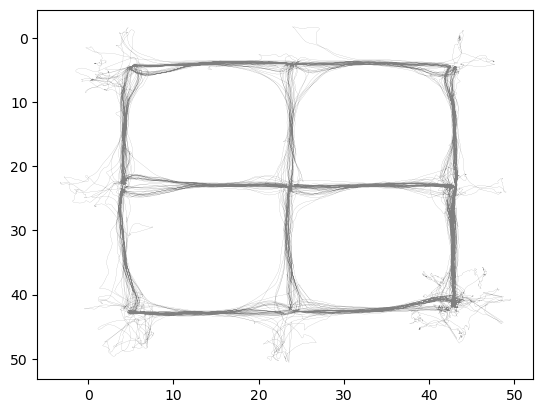

In [8]:
test_coords_df = pd.read_csv('/Users/AdamHarris/Desktop/mEC_SLEAP/outputs/bp01_2024-03-21-125921.analysis_cleaned_coordinates.csv')
test_coords_x, test_coords_y = np.array(test_coords_df['head_back.x']), np.array(test_coords_df['head_back.y'])
test_coords = np.column_stack((test_coords_x, test_coords_y))
fig, ax = plt.subplots()
ax.plot(test_coords[:,0], test_coords[:,1], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()

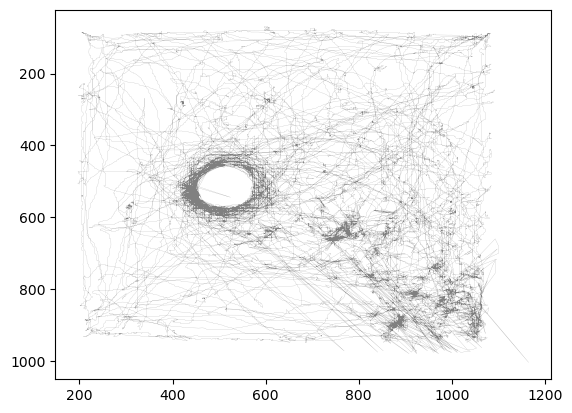

In [10]:
test_coords_df = pd.read_csv("/Users/AdamHarris/Desktop/analysis/labels.v004.000_bp01_2024-03-17-140534.analysis.csv")
test_coords_x, test_coords_y = np.array(test_coords_df['head_back.x']), np.array(test_coords_df['head_back.y'])
test_coords = np.column_stack((test_coords_x, test_coords_y))
fig, ax = plt.subplots()
ax.plot(test_coords[:,0], test_coords[:,1], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()


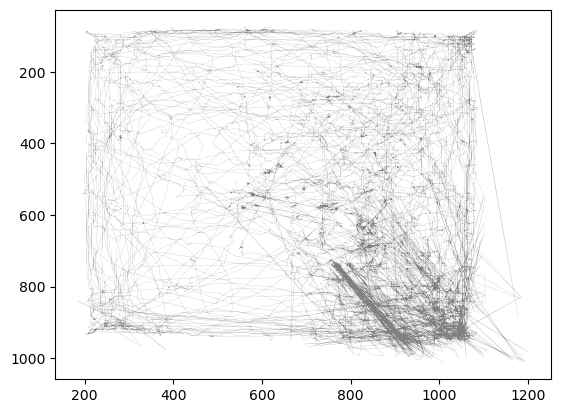

In [11]:
test_coords_df = pd.read_csv('/Users/AdamHarris/Desktop/analysis 2/labels.v003.000_bp01_2024-03-15-144543.analysis.csv')
test_coords_x, test_coords_y = np.array(test_coords_df['head_back.x']), np.array(test_coords_df['head_back.y'])
test_coords = np.column_stack((test_coords_x, test_coords_y))
fig, ax = plt.subplots()
ax.plot(test_coords[:,0], test_coords[:,1], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()



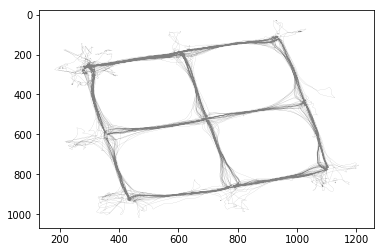

In [58]:
fig, ax = plt.subplots()
ax.plot(test_coords[:,0], test_coords[:,1], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()

In [63]:
import numpy as np
import cv2

def calibrate_and_correct(
    pixel_points: np.ndarray,
    world_points: np.ndarray,
    image_size: tuple,
    flags: int = None
):
    """
    Calibrate camera for radial (and possibly tangential) distortion
    based on 2D correspondences, then return camera matrix and distortion coefficients.
    
    Parameters
    ----------
    pixel_points : np.ndarray
        Nx2 array of pixel coordinates (image points).
    world_points : np.ndarray
        Nx2 array of corresponding physical coordinates (in real-world space, 2D).
    image_size : tuple
        (width, height) of the image in pixels.
    flags : int, optional
        OpenCV flags to refine calibration method. 
        E.g. cv2.CALIB_FIX_ASPECT_RATIO, etc.
    
    Returns
    -------
    camera_matrix : np.ndarray
        The computed camera intrinsic matrix.
    dist_coeffs : np.ndarray
        Distortion coefficients (k1, k2, p1, p2, k3, ...).
    rvecs : list
        Rotation vectors from the calibration routine.
    tvecs : list
        Translation vectors from the calibration routine.
    """
    # We need these in the format (N, 1, 2) for cv2.calibrateCamera
    pixel_points_reshaped = pixel_points.reshape(-1, 1, 2).astype(np.float32)
    world_points_reshaped = world_points.reshape(-1, 1, 2).astype(np.float32)
    
    # Because we're doing a planar approximation, we can treat the real-world points as if z=0
    # However, OpenCV calibrateCamera expects 3D object points for the real-world coords.
    # So let's just embed them in 3D as (x, y, 0).
    object_points_3d = np.hstack([world_points, np.zeros((world_points.shape[0], 1))])
    object_points_3d = object_points_3d.reshape(-1, 1, 3).astype(np.float32)
    
    # We must pass a list of arrays: each array is the correspondences for a single view.
    # If we have only one set of correspondences, it's like we have 1 "image" of that plane.
    object_points_list = [object_points_3d]
    image_points_list = [pixel_points_reshaped]
    
    # Initialize a guess for the camera matrix
    # fx ~ fy ~ some fraction of image size, and principal point near the center
    focal_length = 0.8 * image_size[0]
    cx, cy = image_size[0] / 2.0, image_size[1] / 2.0
    camera_matrix_init = np.array([[focal_length, 0, cx],
                                   [0, focal_length, cy],
                                   [0,           0,  1]], dtype=np.float32)
    
    dist_coeffs_init = np.zeros(5)  # [k1, k2, p1, p2, k3] etc.
    
    if flags is None:
        # Default to something that tries to solve k1, k2, p1, p2, k3
        flags = 0

    # calibrateCamera returns:
    #   rms_error, camera_matrix, dist_coeffs, rvecs, tvecs
    rms, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points_list,
        image_points_list,
        image_size,
        camera_matrix_init,
        dist_coeffs_init,
        flags=flags
    )
    
    print(f"Calibration RMS re-projection error: {rms:.4f}")
    print("Camera Matrix:\n", camera_matrix)
    print("Distortion Coeffs:\n", dist_coeffs.ravel())
    
    return camera_matrix, dist_coeffs, rvecs, tvecs

def undistort_points(
    pixel_points: np.ndarray,
    camera_matrix: np.ndarray,
    dist_coeffs: np.ndarray
) -> np.ndarray:
    """
    Undistort pixel points given the camera matrix and distortion coefficients.
    
    Parameters
    ----------
    pixel_points : np.ndarray
        Nx2 array of pixel coordinates.
    camera_matrix : np.ndarray
        3x3 intrinsic camera matrix.
    dist_coeffs : np.ndarray
        Distortion coefficients.
    
    Returns
    -------
    undistorted_points : np.ndarray
        Nx2 array of undistorted (corrected) pixel coordinates.
    """
    # reshape for OpenCV
    points_reshaped = pixel_points.reshape(-1, 1, 2).astype(np.float32)
    
    # Undistort
    undistorted = cv2.undistortPoints(points_reshaped, camera_matrix, dist_coeffs, P=camera_matrix)
    
    # undistorted returns Nx1x2
    undistorted = undistorted.reshape(-1, 2)
    return undistorted

def find_planar_homography(
    pixel_points: np.ndarray,
    world_points: np.ndarray
) -> np.ndarray:
    """
    Estimate a 3x3 homography matrix mapping 2D pixel space to 2D physical world space.
    
    Parameters
    ----------
    pixel_points : np.ndarray
        Nx2 array of (x, y) pixel coordinates.
    world_points : np.ndarray
        Nx2 array of (x, y) physical coordinates in the real world.
        
    Returns
    -------
    H : np.ndarray
        3x3 homography matrix that maps from pixel to physical coordinates.
    """
    # Need float32 for OpenCV
    pixel_points_32 = pixel_points.reshape(-1, 1, 2).astype(np.float32)
    world_points_32 = world_points.reshape(-1, 1, 2).astype(np.float32)
    
    H, mask = cv2.findHomography(pixel_points_32, world_points_32, cv2.RANSAC, 5.0)
    
    return H

def transform_points_homography(
    pixel_points: np.ndarray,
    H: np.ndarray
) -> np.ndarray:
    """
    Apply a 3x3 homography transform to a set of 2D pixel points.
    
    Parameters
    ----------
    pixel_points : np.ndarray
        Nx2 array of pixel coordinates.
    H : np.ndarray
        3x3 homography matrix.
    
    Returns
    -------
    physical_points : np.ndarray
        Nx2 array of physical coordinates.
    """
    # Convert to homogeneous coordinates: (x, y, 1)
    n = pixel_points.shape[0]
    ones = np.ones((n, 1))
    pixel_points_h = np.hstack([pixel_points, ones])
    
    # Transform
    transformed = (H @ pixel_points_h.T).T  # shape Nx3
    
    # Convert back from homogeneous
    transformed_xy = transformed[:, :2] / transformed[:, 2][:, np.newaxis]
    return transformed_xy


def transform_sleap_dataframe_inplace_radialdistortion(df,  camera_matrix, dist_coeffs, pixel_points, world_points):
    """
    For each body-part column pair that looks like <part>.x, <part>.y
    in DataFrame df, transform those pixel coordinates in-place to physical (cm).
    i.e., we overwrite the .x, .y columns with the new values.
    
    df: Pandas DataFrame with columns like 'nose.x', 'nose.y', ...
    camera_matrix, dist_coeffs: camera calibration parameters
    """
    # Find all columns ending with ".x".
    x_cols = [col for col in df.columns if col.endswith('.x')]
    
    for x_col in x_cols:
        # Replace '.x' with '.y' to get the matching y column
        y_col = x_col[:-2] + '.y'
        if y_col not in df.columns:
            # If the matching .y doesn't exist, skip
            continue
        
        # Extract Nx2 array of pixel coordinates
        pixel_coords = df[[x_col, y_col]].values
        
        # Transform
        undistorted_pixel_points = undistort_points(pixel_coords, camera_matrix, dist_coeffs)
        H = find_planar_homography(pixel_points, world_points)
        
        # Now test the transformation on the same points:
        predicted_world_points = transform_points_homography(undistorted_pixel_points, H)
        
        # Overwrite the DataFrame columns in-place
        df[x_col] = predicted_world_points[:, 0]
        df[y_col] = predicted_world_points[:, 1]
    
    # Return df (not strict
    #ly necessary if we modify in-place)
    return df




In [64]:
def process_openfield(
    sleap_csv_path,
    # Additional outputs
    cleaned_coords_csv_path="cleaned_coordinates.csv",
    head_direction_csv_path="head_direction.csv",
    # Bodypart parsing
    bodypart_names=None,
    x_suffix=".x",
    y_suffix=".y",
    # Outlier detection params
    outlier_detection=True,
    distance_threshold=None,
    robust=True,
    multiplier=3.0,
    transform_to_physical=False,
    pixel_pts=None,
    physical_pts=None,
    # Interpolation/smoothing params
    interpolation_method='linear',
    rolling_window=5
):
    """
    1) Load SLEAP CSV
    2) Optionally do outlier detection
    3) Interpolate + smooth
    4) Save cleaned coordinates to CSV
    5) Compute head direction from (head_mid, head_back, ear_L, ear_R), save to CSV

    Args:
        sleap_csv_path: path to the original SLEAP CSV
        cleaned_coords_csv_path: path for saving the post-processed (x,y) CSV
        head_direction_csv_path: path for saving the head orientation CSV
        bodypart_names: if None, infer from columns. Otherwise, list of bodypart strings
        x_suffix, y_suffix: how the SLEAP CSV columns are named (default ".x"/".y")
        outlier_detection: whether to remove large jumps
        distance_threshold: pixel threshold for outliers (or None to auto-calc)
        robust: if True and threshold is None, use median+MAD; else mean+std
        multiplier: factor for outlier detection
        interpolation_method: method for pd.DataFrame.interpolate (e.g. 'linear')
        rolling_window: window size for rolling-average smoothing
    """
    # 1) Load SLEAP CSV
    sleap_df = pd.read_csv(sleap_csv_path)

    
    # 2) Identify bodypart names
    if bodypart_names is None:
        x_cols = [col for col in sleap_df.columns if col.endswith(x_suffix)]
        bodypart_names = [col.replace(x_suffix, "") for col in x_cols]

    # 3) Outlier detection (optional)
    if outlier_detection:
        sleap_df = detect_outliers_by_jump(
            sleap_df, 
            bodypart_names,
            x_suffix,
            y_suffix,
            distance_threshold=distance_threshold,
            robust=robust,
            multiplier=multiplier
        )

    # 4) Interpolate and smooth
    sleap_df = interpolate_and_smooth_coordinates(
        sleap_df,
        bodypart_names,
        x_suffix,
        y_suffix,
        interpolation_method=interpolation_method,
        rolling_window=rolling_window
    )

    # 5 compute affine transform to put into physical coordinates
    if transform_to_physical:
        
        camera_matrix, dist_coeffs, rvecs, tvecs = calibrate_and_correct(
        pixel_points=pixel_pts,
        world_points=physical_pts,
        image_size=image_size
        )
    
        sleap_df = transform_sleap_dataframe_inplace_radialdistortion(sleap_df, camera_matrix, dist_coeffs, pixel_pts, physical_pts)
            

    # ---- (A) SAVE the cleaned coordinates to CSV
    sleap_df.to_csv(cleaned_coords_csv_path, index=False)
    print(f"Cleaned coordinates saved to: {cleaned_coords_csv_path}")

    # 5) Compute head direction angles from head_mid, head_back, ear_L, ear_R
    head_directions_df = compute_head_directions(sleap_df, x_suffix, y_suffix)
    # Save to CSV
    head_directions_df.to_csv(head_direction_csv_path, index=False)
    print(f"Head direction angles saved to: {head_direction_csv_path}")

    


In [82]:
if __name__ == "__main__":
    #------------------------------------------------------------------
    # 1) Example: Suppose we have measured correspondences in (x,y)
    #    in pixels, and we also have the corresponding real-world
    #    coordinates in some length unit (e.g. mm).
    #------------------------------------------------------------------
    
    #import ast
    
    openfield_registration = pd.read_csv("/Users/AdamHarris/Desktop/maze_registration.htsv", sep='\t')

    pixel_coords_of = np.array([list(x) for x in openfield_registration["pixel_coords"].apply(ast.literal_eval)])
    physical_coords_of = np.array([list(x) for x in openfield_registration["physical_coords"].apply(ast.literal_eval)])

    # The size of the camera image in pixels (width, height).
    image_size = (1280, 1024)




    data_folder = r'/Users/AdamHarris/Desktop/big_maze_csvs/CSVs'

    for filename in tqdm(os.listdir(data_folder)):

        sleap_csv = os.path.join(data_folder, filename)

     

        process_openfield(
            sleap_csv_path=sleap_csv,
            cleaned_coords_csv_path=f"/Users/AdamHarris/Desktop/big_maze_csvs/outputs/{filename[16:-4]}_cleaned_coordinates.csv",
            head_direction_csv_path=f"/Users/AdamHarris/Desktop/big_maze_csvs/outputs/{filename[16:-4]}_head_direction.csv",
            bodypart_names=None, #["head_mid", "head_back", "ear_L", "ear_R"],
            x_suffix=".x",
            y_suffix=".y",
            outlier_detection=True,
            distance_threshold=None,   # auto-compute
            robust=True,              # median+MAD approach
            multiplier=4.0,
            transform_to_physical=True,
            pixel_pts=pixel_coords_of,
            physical_pts=physical_coords_of,
            interpolation_method='linear',
            rolling_window=5
        )
    

    #------------------------------------------------------------------
    # 2) Calibrate camera: find camera_matrix + dist_coeffs using
    #    planar correspondences. This helps remove radial distortion.
    #------------------------------------------------------------------
    
    #------------------------------------------------------------------
    # 5) Finally, for new SLEAP-labeled points (pixel coords),
    #    you would do:
    #       new_undistorted = undistort_points(new_pixel_points, ...)
    #       new_physical    = transform_points_homography(new_undistorted, H)
    #    to get them in physical (distortion-corrected) coordinates.
    #------------------------------------------------------------------

  0%|          | 0/12 [00:00<?, ?it/s]

Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-21-181423.analysis_cleaned_coordinates.csv


  8%|▊         | 1/12 [00:32<05:53, 32.09s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-21-181423.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-25-152859.analysis_cleaned_coordinates.csv


 17%|█▋        | 2/12 [00:34<02:26, 14.62s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-25-152859.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-25-153209.analysis_cleaned_coordinates.csv


 25%|██▌       | 3/12 [01:09<03:36, 24.04s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-25-153209.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-18-191403.analysis_cleaned_coordinates.csv


 33%|███▎      | 4/12 [01:43<03:42, 27.78s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-18-191403.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp04_2024-03-21-191927.analysis_cleaned_coordinates.csv


 42%|████▏     | 5/12 [02:14<03:23, 29.13s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp04_2024-03-21-191927.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-17-140534.analysis_cleaned_coordinates.csv


 50%|█████     | 6/12 [02:46<03:00, 30.04s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-17-140534.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-18-191241.analysis_cleaned_coordinates.csv


 58%|█████▊    | 7/12 [02:47<01:42, 20.59s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-18-191241.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-15-144543.analysis_cleaned_coordinates.csv


 67%|██████▋   | 8/12 [03:18<01:34, 23.68s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-15-144543.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-04-03-155448.analysis_cleaned_coordinates.csv


 75%|███████▌  | 9/12 [03:46<01:15, 25.30s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-04-03-155448.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-04-02-165440.analysis_cleaned_coordinates.csv


 83%|████████▎ | 10/12 [04:15<00:52, 26.35s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-04-02-165440.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp04_2024-03-15-155255.analysis_cleaned_coordinates.csv


 92%|█████████▏| 11/12 [04:47<00:28, 28.19s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp04_2024-03-15-155255.analysis_head_direction.csv
Calibration RMS re-projection error: 1.1450
Camera Matrix:
 [[1.27808695e+03 0.00000000e+00 6.19314357e+02]
 [0.00000000e+00 1.27774602e+03 4.82131030e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coeffs:
 [-0.36916606  0.11833045  0.00440679  0.0007219   0.19012394]
Cleaned coordinates saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-26-191116.analysis_cleaned_coordinates.csv


100%|██████████| 12/12 [05:19<00:00, 26.63s/it]

Head direction angles saved to: /Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-26-191116.analysis_head_direction.csv


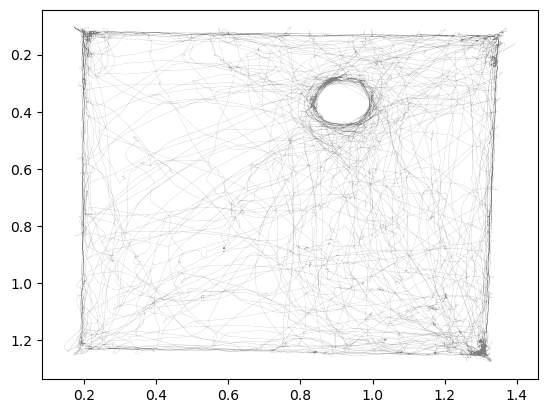

In [77]:
xxx = pd.read_csv('/Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-26-191116.analysis_cleaned_coordinates.csv')
fig, ax = plt.subplots()
ax.plot(xxx['head_back.x'], xxx['head_back.y'], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()

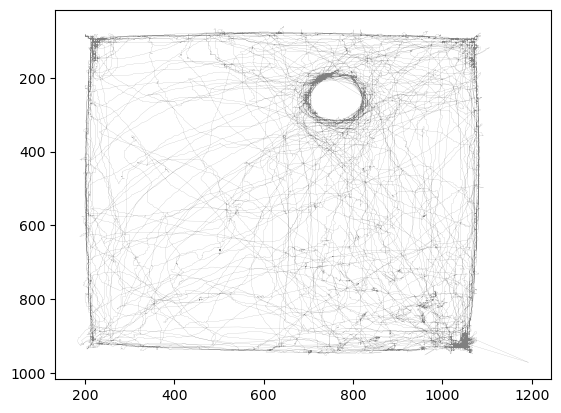

In [78]:
xxx = pd.read_csv('/Users/AdamHarris/Desktop/big_maze_csvs/CSVs/labels.v004.004_bp01_2024-03-26-191116.analysis.csv')
fig, ax = plt.subplots()
ax.plot(xxx['head_back.x'], xxx['head_back.y'], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()

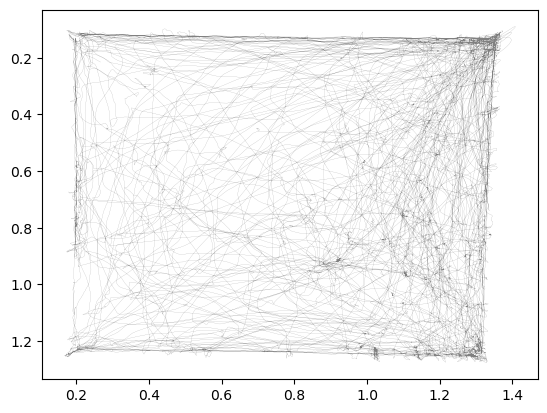

In [81]:
xxx = pd.read_csv('/Users/AdamHarris/Desktop/big_maze_csvs/outputs/bp01_2024-03-21-181423.analysis_cleaned_coordinates.csv')
fig, ax = plt.subplots()
ax.plot(xxx['head_back.x'], xxx['head_back.y'], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()



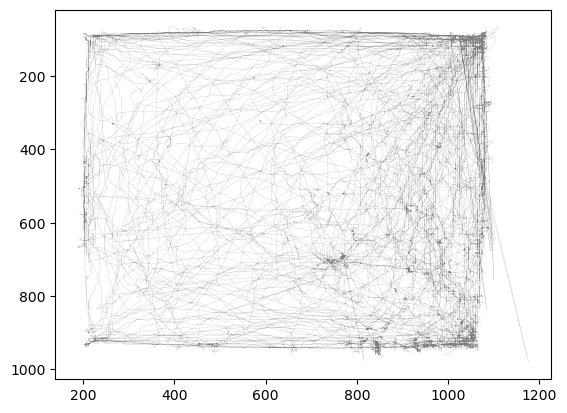

In [80]:
xxx = pd.read_csv('/Users/AdamHarris/Desktop/big_maze_csvs/CSVs/labels.v003.001_bp01_2024-03-21-181423.analysis.csv')
fig, ax = plt.subplots()
ax.plot(xxx['head_back.x'], xxx['head_back.y'], '-', linewidth=0.1, c='grey')
ax.invert_yaxis()
plt.show()
